✅ Dataset loaded successfully with shape: (2848, 6)
            Price   Open   High    Low  Volume  Chg%
Date                                                
2014-01-01  29542  29435  29598  29340    2930  0.25
2014-01-02  29975  29678  30050  29678    3140  1.47
2014-01-03  29727  30031  30125  29539    3050 -0.83
2014-01-04  29279  29279  29279  29279       0 -1.51
2014-01-06  29119  29300  29395  29051   24380 -0.55
🔍 Finding best ARIMA parameters...
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=7.85 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=43660.526, Time=0.28 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=42713.845, Time=0.80 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=2.44 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=43658.527, Time=0.13 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=42413.621, Time=1.59 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=42271.941, Time=2.24 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=

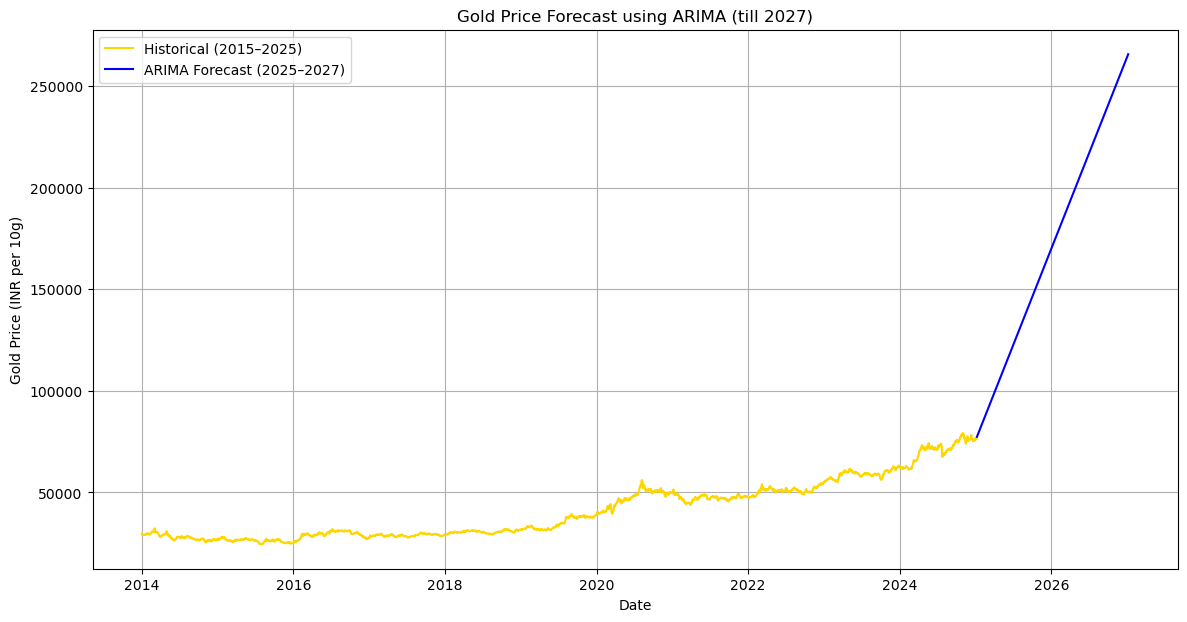


Enter a future date between 2025–2027 to predict gold price:
Date (YYYY-MM-DD): 2020-11-06
⚠️ Date is beyond forecast range (2025–2027).

📊 ARIMA Model Evaluation Metrics (Training Data)
MAE  : 278.32
RMSE : 731.98
MAPE : 0.70%
R²   : 0.997


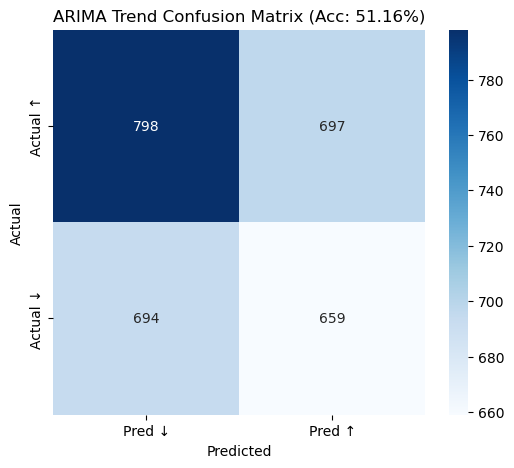

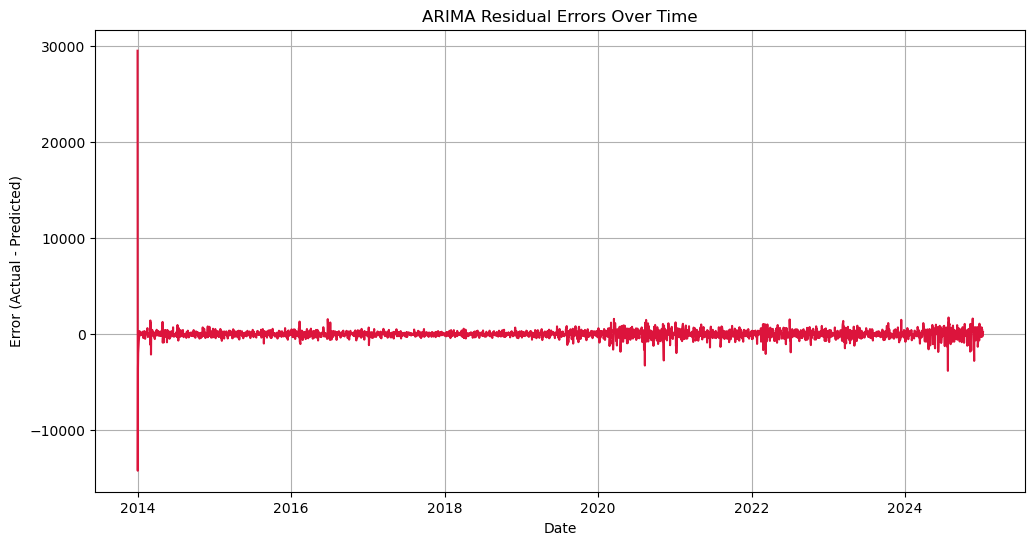

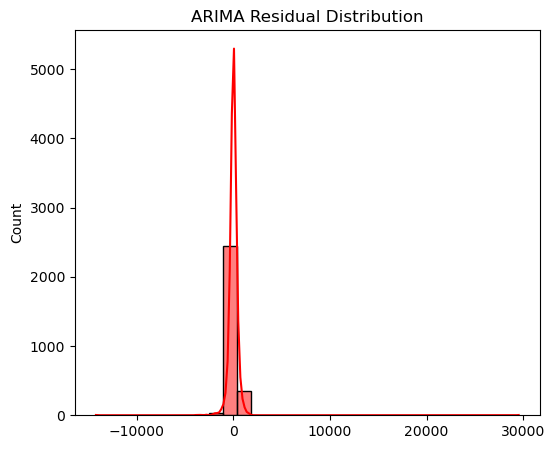


✅ ARIMA forecast saved successfully.


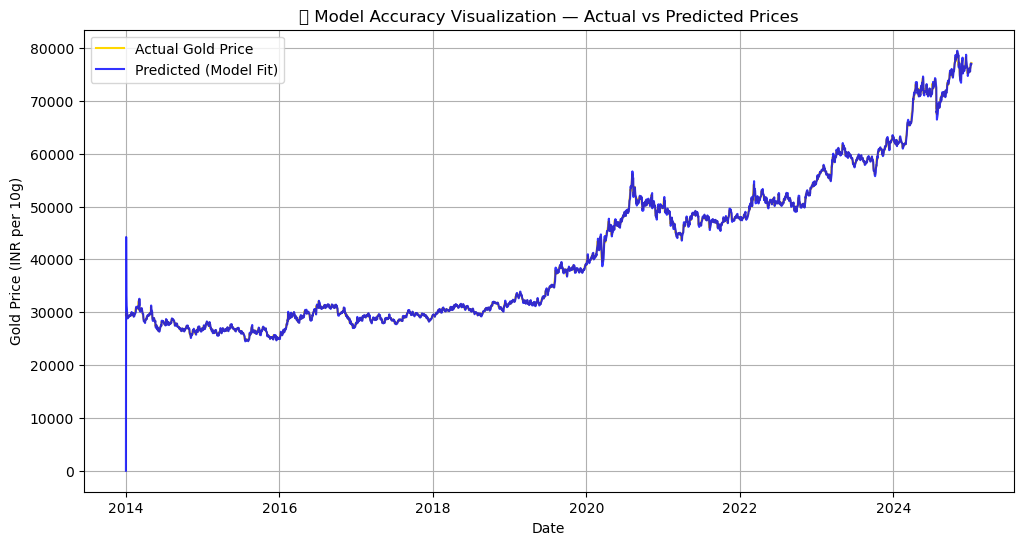

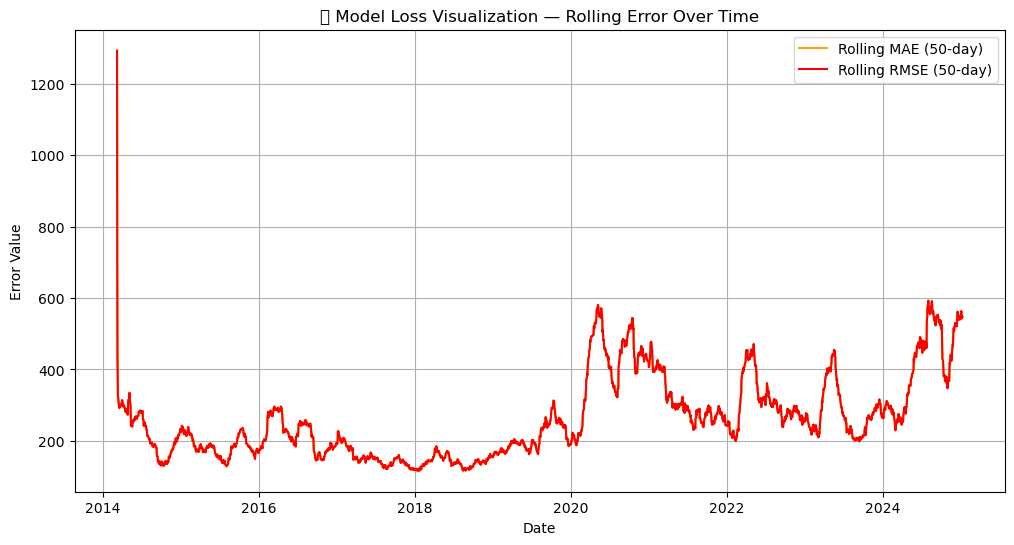

In [1]:
# -------------------------------------------------------------
# 🪙 GOLD PRICE FORECAST (2015–2027) USING ARIMA + METRICS
# -------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# -------------------------------------------------------------
# Step 1: Load Dataset
# -------------------------------------------------------------
data = pd.read_csv('../data/daily_gold_2015_2025.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data.sort_index()

print("✅ Dataset loaded successfully with shape:", data.shape)
print(data.head())

# -------------------------------------------------------------
# Step 2: Fit ARIMA Model
# -------------------------------------------------------------
print("🔍 Finding best ARIMA parameters...")
auto_model = auto_arima(data['Price'], seasonal=False, trace=True, stepwise=True, suppress_warnings=True)
print("\n✅ Best ARIMA order:", auto_model.order)

model = ARIMA(data['Price'], order=auto_model.order)
model_fit = model.fit()
print(model_fit.summary())

# -------------------------------------------------------------
# Step 3: Forecast till 2027
# -------------------------------------------------------------
forecast_steps = 730  # ~2 years
forecast = model_fit.forecast(steps=forecast_steps)

last_date = data.index[-1]
future_dates = pd.date_range(start=last_date, periods=forecast_steps+1, freq='D')[1:]
forecast_df = pd.DataFrame({'Date': future_dates, 'Forecasted_Price': forecast}).set_index('Date')

# -------------------------------------------------------------
# Step 4: Plot Forecast
# -------------------------------------------------------------
plt.figure(figsize=(14,7))
plt.plot(data['Price'], label='Historical (2015–2025)', color='gold')
plt.plot(forecast_df['Forecasted_Price'], label='ARIMA Forecast (2025–2027)', color='blue')
plt.title("Gold Price Forecast using ARIMA (till 2027)")
plt.xlabel("Date")
plt.ylabel("Gold Price (INR per 10g)")
plt.legend()
plt.grid(True)
plt.show()

# -------------------------------------------------------------
# Step 5: Predict for a Specific Date
# -------------------------------------------------------------
print("\nEnter a future date between 2025–2027 to predict gold price:")
user_date = input("Date (YYYY-MM-DD): ")
user_date = pd.to_datetime(user_date)

if user_date in forecast_df.index:
    predicted_price = forecast_df.loc[user_date, 'Forecasted_Price']
    print(f"\n💰 Predicted Gold Price on {user_date.date()}: ₹{predicted_price:.2f}")
else:
    print("⚠️ Date is beyond forecast range (2025–2027).")

# -------------------------------------------------------------
# Step 6: Accuracy Metrics on Training Data
# -------------------------------------------------------------
train_pred = model_fit.fittedvalues
train_actual = data['Price'].iloc[len(data['Price']) - len(train_pred):]

mae = mean_absolute_error(train_actual, train_pred)
rmse = np.sqrt(mean_squared_error(train_actual, train_pred))
mape = np.mean(np.abs((train_actual - train_pred) / train_actual)) * 100
r2 = r2_score(train_actual, train_pred)

print("\n📊 ARIMA Model Evaluation Metrics (Training Data)")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAPE : {mape:.2f}%")
print(f"R²   : {r2:.3f}")

# -------------------------------------------------------------
# Step 7: Trend Direction Confusion Matrix
# -------------------------------------------------------------
data['Actual_Trend'] = np.where(data['Price'].diff() > 0, 1, 0)
data['Pred_Trend'] = np.where(train_pred.diff() > 0, 1, 0)

TP = np.sum((data['Actual_Trend'] == 1) & (data['Pred_Trend'] == 1))
TN = np.sum((data['Actual_Trend'] == 0) & (data['Pred_Trend'] == 0))
FP = np.sum((data['Actual_Trend'] == 0) & (data['Pred_Trend'] == 1))
FN = np.sum((data['Actual_Trend'] == 1) & (data['Pred_Trend'] == 0))
directional_accuracy = (TP + TN) / (TP + TN + FP + FN)

conf_matrix = np.array([[TP, FP],
                        [FN, TN]])

plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred ↓', 'Pred ↑'], yticklabels=['Actual ↑', 'Actual ↓'])
plt.title(f"ARIMA Trend Confusion Matrix (Acc: {directional_accuracy*100:.2f}%)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# -------------------------------------------------------------
# Step 8: Residual (Loss) Plot
# -------------------------------------------------------------
residuals = data['Price'] - train_pred

plt.figure(figsize=(12,6))
plt.plot(data.index, residuals, color='crimson')
plt.title("ARIMA Residual Errors Over Time")
plt.xlabel("Date")
plt.ylabel("Error (Actual - Predicted)")
plt.grid(True)
plt.show()

plt.figure(figsize=(6,5))
sns.histplot(residuals, bins=30, kde=True, color='red')
plt.title("ARIMA Residual Distribution")
plt.show()

# -------------------------------------------------------------
# Step 9: Save Forecast
# -------------------------------------------------------------
print("\n✅ ARIMA forecast saved successfully.")

# 1️⃣ Accuracy Visualization — Actual vs Predicted
plt.figure(figsize=(12,6))
plt.plot(data.index, data['Price'], label='Actual Gold Price', color='gold')
plt.plot(data.index, model_fit.fittedvalues, label='Predicted (Model Fit)', color='blue', alpha=0.8)
plt.title("📈 Model Accuracy Visualization — Actual vs Predicted Prices")
plt.xlabel("Date")
plt.ylabel("Gold Price (INR per 10g)")
plt.legend()
plt.grid(True)
plt.show()

# 2️⃣ Loss Visualization — Rolling MAE and RMSE over time
window = 50  # number of days in rolling window
mae_series = np.abs(data['Price'] - model_fit.fittedvalues).rolling(window).mean()
rmse_series = np.sqrt((data['Price'] - model_fit.fittedvalues)**2).rolling(window).mean()

plt.figure(figsize=(12,6))
plt.plot(mae_series, label=f"Rolling MAE ({window}-day)", color='orange')
plt.plot(rmse_series, label=f"Rolling RMSE ({window}-day)", color='red')
plt.title("📉 Model Loss Visualization — Rolling Error Over Time")
plt.xlabel("Date")
plt.ylabel("Error Value")
plt.legend()
plt.grid(True)
plt.show()



NameError: name 'data' is not defined

<Figure size 1200x600 with 0 Axes>